In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
df = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Netflix_Prize_data.parquet')
df_mov = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Netflix_Movies.parquet')

In [ ]:
df[df.customer_id==2059652].head()

,movie_id,customer_id,rating,date
547,2,2059652,4,2005-09-05
244742,48,2059652,5,2003-12-28
313747,83,2059652,4,2003-03-03
717008,191,2059652,4,2004-12-18
817113,197,2059652,4,2005-04-10


In [ ]:
print(df_mov.dtypes)
print(df.dtypes)

movie_id        object
release_year    object
title           object
dtype: object
movie_id        int64
customer_id     int64
rating          int64
date           object
dtype: object


In [ ]:
# Merge the data to make one dataframe
df_mov.movie_id = df_mov.movie_id.astype(int)
df = pd.merge(df, df_mov, on='movie_id')
df[df.customer_id==2059652].head()

,movie_id,customer_id,rating,date,release_year,title
547,2,2059652,4,2005-09-05,2004,Isle of Man TT 2004 Review
244742,48,2059652,5,2003-12-28,2001,Justice League
313747,83,2059652,4,2003-03-03,1983,Silkwood
717008,191,2059652,4,2004-12-18,2003,X2: X-Men United
817113,197,2059652,4,2005-04-10,2004,Taking Lives


In [ ]:
print(df.release_year.min())
print(df.release_year.max())

1896
NULL


In [ ]:
# converting the release year to int
import numpy as np
df['release_year'] = df['release_year'].replace('NULL', np.nan)
df['release_year'] = df['release_year'].astype(float).astype('Int64')
df.isnull().sum()

movie_id          0
customer_id       0
rating            0
date              0
release_year    965
title             0
dtype: int64

In [ ]:
print('Min release year',df.release_year.min())
print('Max release year',df.release_year.max())

Min release year 1896
Max release year 2005


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.groupby(df.release_year).agg({'movie_id':'nunique'}).tail(10)

,movie_id
release_year,
1996,533
1997,653
1998,743
1999,965
2000,1234
2001,1184
2002,1310
2003,1271
2004,1436


In [ ]:
df = df[df.release_year.isin([2003,2004,2005])].copy()
df.shape

(22016745, 6)

In [ ]:
# Converting the data to networkx graph data
import pandas as pd
import networkx as nx
import time
import pickle

df_sample = df.sample(frac=0.002)

G = nx.Graph()
start_time = time.time()

for index, row in df_sample.iterrows():
    G.add_node(row['customer_id'], type='customer')
    G.add_node(row['movie_id'], type='movie')
    G.add_edge(row['customer_id'], row['movie_id'], rating=row['rating'], date=row['date'], releasedate=row['release_year'])

end_time = time.time()
print('Time elapsed for sample processing:', end_time - start_time)

node_list = list(G.nodes())
node_mapping = {old_id: new_id for new_id, old_id in enumerate(node_list)}

G = nx.relabel_nodes(G, node_mapping)

print(f"Total number of nodes after reindexing: {G.number_of_nodes()}")
print(f"Sample of new node mappings: {list(node_mapping.items())[:5]}")

pickle_path = '/content/drive/My Drive/Colab Notebooks/Netflix_Prize_data_graph.pkl'

with open(pickle_path, 'wb') as f:
    pickle.dump(G, f)

with open(pickle_path, 'rb') as f:
    G = pickle.load(f)


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
# Number of nodes: 23758
# Number of edges: 20096

Number of nodes: 41756
Number of edges: 44033


In [ ]:
# Print some nodes
print("Some example nodes:")
print(list(G.nodes(data=True))[:5])  # prints first 5 nodes with their data

# Print some edges
print("Some example edges:")
print(list(G.edges(data=True))[:5])  # prints first 5 edges with their attributes


Some example nodes:
[(0, {'type': 'customer'}), (1, {'type': 'movie'}), (2, {'type': 'customer'}), (3, {'type': 'movie'}), (4, {'type': 'customer'})]
Some example edges:
[(0, 1, {'rating': 4, 'date': '2005-03-25', 'releasedate': 2004}), (1, 38, {'rating': 3, 'date': '2005-05-11', 'releasedate': 2004}), (1, 317, {'rating': 3, 'date': '2005-03-29', 'releasedate': 2004}), (1, 325, {'rating': 3, 'date': '2004-11-18', 'releasedate': 2004}), (1, 412, {'rating': 5, 'date': '2005-12-06', 'releasedate': 2004})]


In [ ]:
# Get degrees of all nodes
degrees = dict(G.degree())
max_degree_node = max(degrees, key=degrees.get)
print(f"Node with the highest degree: {max_degree_node} has a degree of {degrees[max_degree_node]}")


Node with the highest degree: 999 has a degree of 394


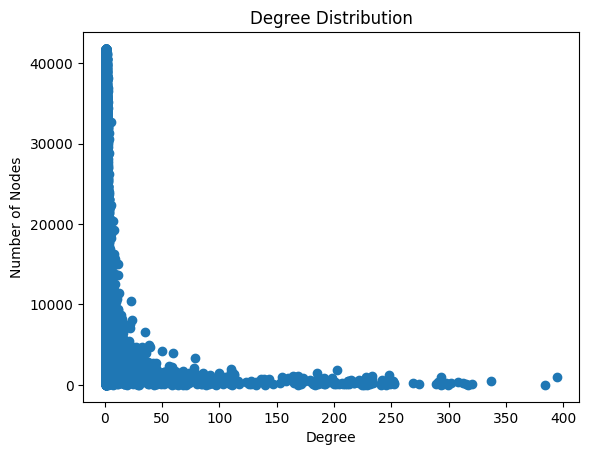

In [ ]:
import matplotlib.pyplot as plt

# Plot degree distribution
degrees = [degree for node, degree in G.degree()]
node = [node for node, degree in G.degree()]

plt.scatter(degrees,node)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()


In [ ]:
connected_components = nx.connected_components(G)
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")


Number of connected components: 817


In [ ]:
from collections import defaultdict
import networkx as nx

def get_clust(a):
    b = nx.clustering(a)
    return b

# Function to get the degree of each node in the graph
def get_deg(a):
    b = a.degree()
    b = [(c, d) for c, d in b]
    return b

def avg_clust_by_deg(a, b):
    a1 = defaultdict(list)

    # Iterate over each tuple in list 'a'
    for c, d in a:
        if c in b:
            e = b[c]
            a1[d].append(e)

    # lists of degrees and their average clustering
    dg2 = list(a1.keys())
    ac2 = [sum(f) / len(f) for f in a1.values()]

    return dg2, ac2

degree = get_deg(G)
clust = get_clust(G)
degr1, avg1 = avg_clust_by_deg(degree, clust)

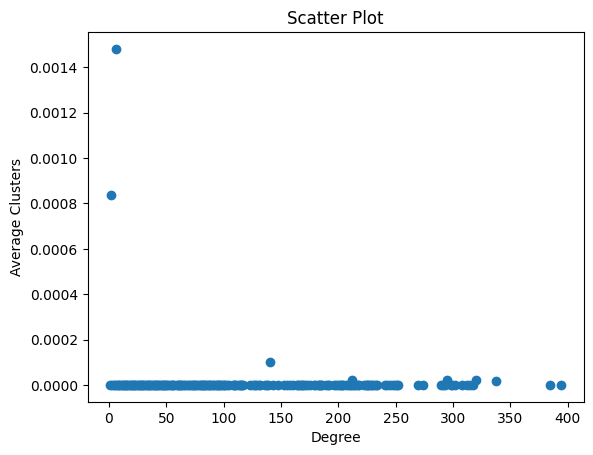

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(degr1, avg1)

plt.title('Scatter Plot')
plt.xlabel('Degree')
plt.ylabel('Average Clusters')

plt.show()

In [ ]:
import time

def Degree_Distribution(G):
    start_time = time.time()

    degree = G.degree()
    degree = [ deg for (v,deg) in degree ]
    print(sum(degree))
    print(len(degree))
    avg_degree_dist = sum(degree)/len(degree)
    print('Average degree distribution is = ',avg_degree_dist)
    plot_distribution(degree, xlabel='Degree ($k$)',
                  ylabel='Number of nodes with degree $k$ ($N_k$)', title='Degree distributions')

    end_time = time.time()
    print('Time elapsed Degree_Dist = ',end_time - start_time)

def CC_Distribution(G):
    start_time = time.time()
    cc_sorted = sorted(nx.connected_components(G), key=len, reverse=True)
    # print statistics of the top 5 components (if exist)
    topcc = min(len(cc_sorted), 5)
    for i in  range(topcc):
        cc = cc_sorted[i]
        cc_graph = G.subgraph(cc)
        n = cc_graph.number_of_nodes()
        m = cc_graph.number_of_edges()
        n_percent = (n/G.number_of_nodes()) * 100
        print("Largest component #", i+1)
        print("Number of vertices:", n, " (", n_percent, ")", "\nNumber of edges: ", m, "\n")

    cc_sizes = [len(c) for c in cc_sorted]
    plot_distribution(cc_sizes, xlabel='Weakly connected component size',
                  ylabel='Count', title='Connected component size distributions')

    end_time = time.time()
    print('Time elapsed CC_Dist = ',end_time - start_time)

def Clustering_Analysis(G):
    start_time = time.time()
    clust = nx.clustering(G)
    local_clust_coefficient = [ v for v in clust.values() ]
    avg_clust_coefficient = sum(local_clust_coefficient)/G.number_of_nodes()
    print("Average clustering coefficient: ", avg_clust_coefficient)
    #plot the distribution of clustering coefficient
    plot_distribution(local_clust_coefficient, xlabel='Clustering coefficient',
                  ylabel='Number of vertices', title='Clustering coefficient distributions',
                      xlog=False, ylog=True, showLine=False)
    end_time = time.time()
    print('Time elapsed clustering analysis = ',end_time - start_time)

def ShortestPaths_Analysis(G):

    start_time = time.time()

    cc_sorted = sorted(nx.connected_components(G), key=len, reverse=True)

    # find shortest paths in top 5 components
    topcc = min(len(cc_sorted), 2)
    for i in  range(topcc) :
        cc = cc_sorted[i]
        cc_graph = G.subgraph(cc)

        if(len(cc)>30000):
            print("This component is too large. Using ten single-source shortest paths.")
            cc = list(cc)
            cc_graph = G.subgraph(cc)
            shortest_path_lens = []
            for i in range(10):
                length = nx.single_source_shortest_path_length(cc_graph, cc[i])
                shortest_path_lens += [ v for v in length.values() ]
        else:
            all_shortest_path_dict = dict(nx.all_pairs_shortest_path_length(cc_graph))
            shortest_path_lens = []
            for val1 in all_shortest_path_dict.values():
                for val in val1.values():
                    shortest_path_lens.append(val)

        plot_distribution(shortest_path_lens, xlabel='Shortest path lengths (hops)',
                  ylabel='Number of paths', title='Shortest path lengths distributions',
                      xlog=False, ylog=False, showLine=True, intAxis=True)

    end_time = time.time()
    print('Time elapsed shortest path =',end_time - start_time)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')
#plt.style.use('seaborn-ticks')
#plt.style.use('seaborn-notebook')
plt.rcParams['lines.linewidth']=3
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=14


def plot_distribution (data, xlabel='', ylabel='', title='', xlog = True, ylog= True, showLine=False, intAxis=False) :
    counts = {}
    for item in data :
        if item not in counts :
            counts [ item ] = 0
        counts [ item ] += 1
    counts = sorted ( counts.items () )
    fig = plt.figure ()
    ax = fig.add_subplot (111)
    ax.scatter ([ k for (k , v ) in counts ] , [ v for (k , v ) in counts ])
    if(len(counts)<20):  # for tiny graph
        showLine=True
    if showLine==True:
        ax.plot ([ k for (k , v ) in counts ] , [ v for (k , v ) in counts ])
    if xlog == True:
        ax.set_xscale ( 'log')
    if ylog == True:
        ax.set_yscale ( 'log')
    if intAxis == True:
        gca = fig.gca()
        gca.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel ( xlabel)
    ax.set_ylabel ( ylabel )
    plt.title ( title )
    #fig.savefig ( "degree_distribution.png" )

def plot_degree_bar (G) :
    degs = {}
    for n in G.nodes () :
        deg = G.degree ( n )
        if deg not in degs :
            degs [ deg ] = 0
        degs [ deg ] += 1
    items = sorted ( degs.items () )
    fig = plt.figure ()
    ax = fig.add_subplot (111)
    print(items)
    ax.bar([ k for (k , v ) in items ] , [ v for (k , v ) in items ])
    ax.set_xlabel ( 'Degree ($k$)')
    ax.set_ylabel ( 'Number of nodes with degree $k$ ($N_k$)')


88066
41756
Average degree distribution is =  2.1090621707060064
Time elapsed Degree_Dist =  0.037328243255615234


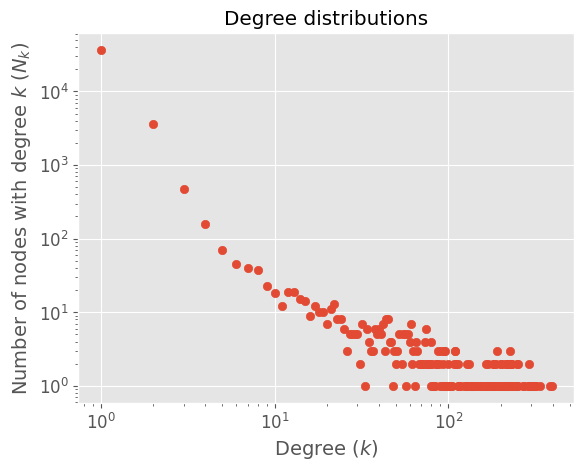

In [ ]:
Degree_Distribution(G)

Largest component # 1
Number of vertices: 39252  ( 94.00325701695564 ) 
Number of edges:  42345 

Largest component # 2
Number of vertices: 23  ( 0.05508190439697289 ) 
Number of edges:  22 

Largest component # 3
Number of vertices: 19  ( 0.045502442762716734 ) 
Number of edges:  18 

Largest component # 4
Number of vertices: 18  ( 0.043107577354152694 ) 
Number of edges:  17 

Largest component # 5
Number of vertices: 15  ( 0.03592298112846058 ) 
Number of edges:  14 

Time elapsed CC_Dist =  0.27834177017211914


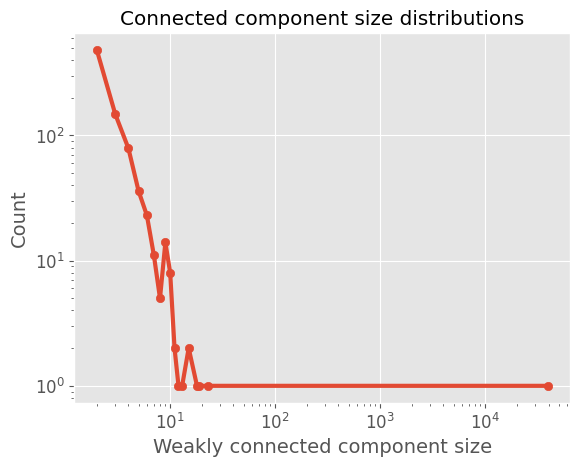

In [ ]:
CC_Distribution(G)

Average clustering coefficient:  7.344751575128562e-05
Time elapsed clustering analysis =  0.7739672660827637


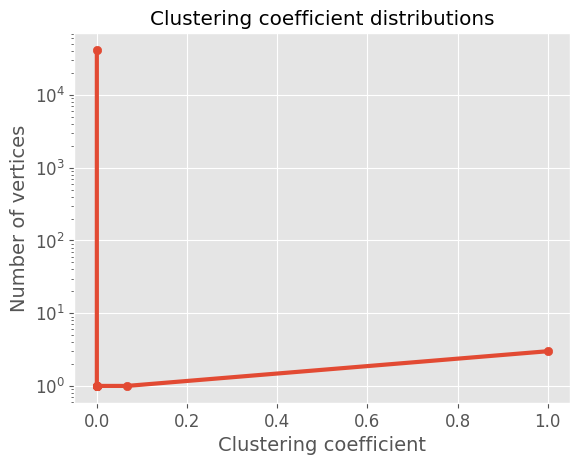

In [ ]:
Clustering_Analysis(G)

This component is too large. Using ten single-source shortest paths.
Time elapsed shortest path = 1.740839958190918


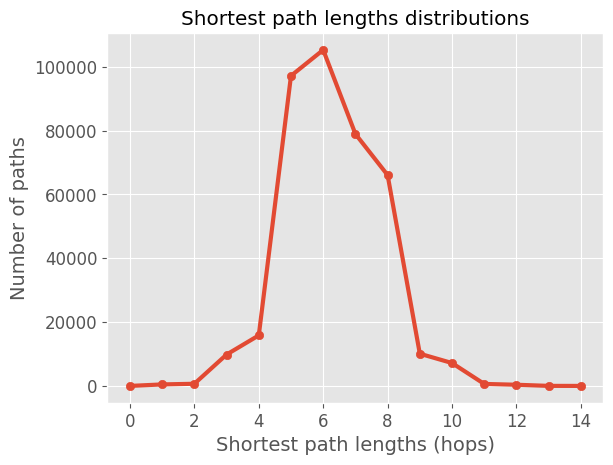

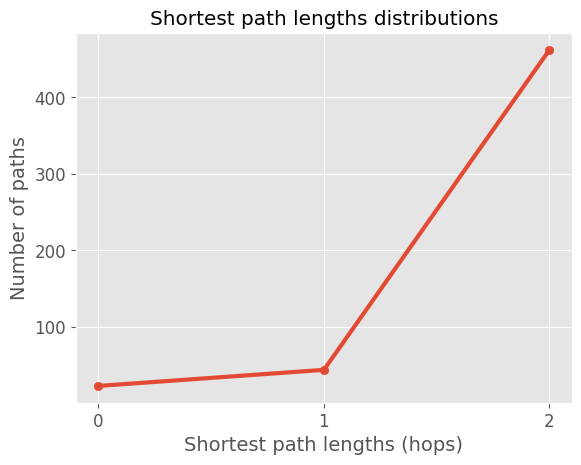

In [ ]:
ShortestPaths_Analysis(G)

In [ ]:
node_data = []

with open('/content/drive/My Drive/Colab Notebooks/node_data.label', 'w') as file:
  for n, d in G.nodes(data=True):
      node_type = d.get('type')  # Retrieve the type of node
      type_label = 0 if node_type == 'movie' else 1 if node_type == 'customer' else None
      node_data.append(f"{n} {type_label}")
      file.write(f"{n} {type_label}\n")

print(node_data[:10])

['0 1', '1 0', '2 1', '3 0', '4 1', '5 0', '6 1', '7 0', '8 1', '9 0']


In [ ]:

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Number of nodes:  41756
Number of edges:  44033


In [ ]:
# ============================================================================================================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Netflix_Prize_data.parquet')
print(df.shape)
df_mov = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Netflix_Movies.parquet')
print(df_mov.shape)
df_mov.movie_id = df_mov.movie_id.astype(int)
df = pd.merge(df, df_mov, on='movie_id')
df[df.customer_id==2059652].head()

(100480507, 4)
(17770, 3)


,movie_id,customer_id,rating,date,release_year,title
547,2,2059652,4,2005-09-05,2004,Isle of Man TT 2004 Review
244742,48,2059652,5,2003-12-28,2001,Justice League
313747,83,2059652,4,2003-03-03,1983,Silkwood
717008,191,2059652,4,2004-12-18,2003,X2: X-Men United
817113,197,2059652,4,2005-04-10,2004,Taking Lives


In [ ]:
import numpy as np
df['release_year'] = df['release_year'].replace('NULL', np.nan)
df['release_year'] = df['release_year'].astype(float).astype('Int64')
print(df.isnull().sum())
df.dropna(inplace=True)
df.isnull().sum()

movie_id          0
customer_id       0
rating            0
date              0
release_year    965
title             0
dtype: int64


movie_id        0
customer_id     0
rating          0
date            0
release_year    0
title           0
dtype: int64

In [ ]:
df = df[df.release_year.isin([2004,2005])].copy()
df = df.sample(frac=0.002, random_state=42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.shape)
df.groupby(df.release_year).agg({'movie_id':'nunique'})


(24880, 6)


,movie_id
release_year,
2004,852
2005,264


In [ ]:
#!pip install tensorflow_recommenders
print(df.shape)

(24880, 6)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split

df = df[['movie_id', 'customer_id', 'rating']].copy()
# Splitting the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Creating TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_df))
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_df))
print(f"Train dataset element shape: {train_dataset.take(1).element_spec}")
print(f"Test dataset element shape: {test_dataset.take(1).element_spec}")

print(f"Train dataset element shape: {len(train_dataset)}")
print(f"Test dataset element shape: {len(test_dataset)}")

Train dataset element shape: {'movie_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'customer_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'rating': TensorSpec(shape=(), dtype=tf.int64, name=None)}
Test dataset element shape: {'movie_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'customer_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'rating': TensorSpec(shape=(), dtype=tf.int64, name=None)}
Train dataset element shape: 19904
Test dataset element shape: 4976


In [ ]:

import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split

# Checking if GPU is available and list them
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:

# Defining the movie recommendation model class, a TensorFlow Recommenders (TFRS) based model,
# but it does not actually implement a Graph Neural Network (GNN).
# Instead, it utilizes embedding layers for users and movies,
# and dense layers to process the interactions between these embeddings
class MovieRecommendationModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.movie_embeddings = tf.keras.layers.Embedding(input_dim=df['movie_id'].max() + 1, output_dim=embedding_dimension)
        self.user_embeddings = tf.keras.layers.Embedding(input_dim=df['customer_id'].max() + 1, output_dim=embedding_dimension)

        # Using GRU as a placeholder.
        self.interaction_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu')
        ])

        # Final prediction layer
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user_embeddings = self.user_embeddings(inputs['customer_id'])
        movie_embeddings = self.movie_embeddings(inputs['movie_id'])
        interaction = tf.concat([user_embeddings, movie_embeddings], axis=1)
        interaction_output = self.interaction_layers(interaction)
        return self.output_layer(interaction_output)

    def compute_loss(self, inputs, training=False):
        labels = inputs['rating']
        predictions = self(inputs, training=training)
        return tf.keras.losses.MeanSquaredError()(labels, predictions)

In [ ]:


model = MovieRecommendationModel()# compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=model.compute_loss)


In [ ]:

train_dataset = train_dataset.shuffle(1000).batch(32).cache().prefetch(tf.data.experimental.AUTOTUNE) #preparing the dataset for model


In [ ]:

model.fit(train_dataset, epochs=10)# model training

Epoch 1/10
622/622 [==============================] - 16s 23ms/step - loss: 1.3525 - regularization_loss: 0.0000e+00 - total_loss: 1.3525
Epoch 2/10
622/622 [==============================] - 13s 20ms/step - loss: 0.5444 - regularization_loss: 0.0000e+00 - total_loss: 0.5444
Epoch 3/10
622/622 [==============================] - 13s 20ms/step - loss: 0.3767 - regularization_loss: 0.0000e+00 - total_loss: 0.3767
Epoch 4/10
622/622 [==============================] - 13s 20ms/step - loss: 0.3873 - regularization_loss: 0.0000e+00 - total_loss: 0.3873
Epoch 5/10
622/622 [==============================] - 13s 20ms/step - loss: 0.3222 - regularization_loss: 0.0000e+00 - total_loss: 0.3222
Epoch 6/10
622/622 [==============================] - 13s 20ms/step - loss: 0.2882 - regularization_loss: 0.0000e+00 - total_loss: 0.2882
Epoch 7/10
622/622 [==============================] - 13s 20ms/step - loss: 0.2445 - regularization_loss: 0.0000e+00 - total_loss: 0.2445
Epoch 8/10
622/622 [==============

In [ ]:

test_dataset = test_dataset.batch(32).cache().prefetch(tf.data.experimental.AUTOTUNE)# test dataset for evaluation

test_loss = model.evaluate(test_dataset)#evaluate the model on the test dataset
print("Test Loss:", test_loss)


156/156 [==============================] - 0s 2ms/step - loss: 1.4097 - regularization_loss: 0.0000e+00 - total_loss: 1.4097
Test Loss: [1.5964601039886475, 0, 1.5964601039886475]


In [ ]:
# Hyperparameter Tuning
# For hyperparameter tuning, we  used a more systematic approach like using Keras Tuner
#!pip install keras-tuner

import tensorflow as tf
import tensorflow_recommenders as tfrs
from keras_tuner import HyperModel, RandomSearch

class HyperMovieRecommendationModel(HyperModel):
    def __init__(self, max_movie_id, max_customer_id):
        self.max_movie_id = max_movie_id
        self.max_customer_id = max_customer_id

    def build(self, hp):
        model = MovieRecommendationModel(        #defining the model with hyperparameters
            max_movie_id=self.max_movie_id,
            max_customer_id=self.max_customer_id,
            embedding_dimension=hp.Int('embedding_dimension', min_value=16, max_value=64, step=16),
            dense_units=hp.Int('dense_units', min_value=64, max_value=256, step=64)
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss=model.compute_loss)
        return model

class MovieRecommendationModel(tfrs.Model):
    def __init__(self, max_movie_id, max_customer_id, embedding_dimension, dense_units):
        super().__init__()
        self.movie_embeddings = tf.keras.layers.Embedding(input_dim=max_movie_id + 1, output_dim=embedding_dimension)
        self.user_embeddings = tf.keras.layers.Embedding(input_dim=max_customer_id + 1, output_dim=embedding_dimension)
        self.interaction_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(dense_units, activation='relu'),
            tf.keras.layers.Dense(dense_units // 2, activation='relu')
        ])
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user_embeddings = self.user_embeddings(inputs['customer_id'])
        movie_embeddings = self.movie_embeddings(inputs['movie_id'])
        interaction = tf.concat([user_embeddings, movie_embeddings], axis=1)
        interaction_output = self.interaction_layers(interaction)
        return self.output_layer(interaction_output)

    def compute_loss(self, inputs, training=False):
        labels = inputs['rating']
        predictions = self(inputs, training=training)
        return tf.keras.losses.MeanSquaredError()(labels, predictions)


In [ ]:
max_movie_id = df['movie_id'].max()
max_customer_id = df['customer_id'].max()

hypermodel = HyperMovieRecommendationModel(max_movie_id, max_customer_id)# setting the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='movie_recommendation_tuning'
)

# hyperparameter search
tuner.search(train_dataset, validation_data=test_dataset, epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])


Trial 10 Complete [00h 01m 30s]
val_loss: 1.6874433159828186

Best val_loss So Far: 1.6316914558410645
Total elapsed time: 00h 12m 55s


In [ ]:
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

# 'model' is trained model and 'test_dataset' is prepared separately
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
#print(f"Mean Absolute Error: {results[1]}")
print(f"Root Mean Squared Error: {results[2]}")



156/156 [==============================] - 0s 2ms/step - loss: 1.4097 - regularization_loss: 0.0000e+00 - total_loss: 1.4097
Test Loss: 1.5964601039886475
Mean Absolute Error: 0
Root Mean Squared Error: 1.5964601039886475


In [ ]:
class MovieRecommendationModel(tfrs.Model):
    def __init__(self, max_movie_id, max_customer_id, embedding_dimension=32, dense_units=128):
        super().__init__()
        self.movie_embeddings = tf.keras.layers.Embedding(input_dim=max_movie_id + 1, output_dim=embedding_dimension)
        self.user_embeddings = tf.keras.layers.Embedding(input_dim=max_customer_id + 1, output_dim=embedding_dimension)
        self.interaction_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(dense_units, activation='relu'),
            tf.keras.layers.Dense(dense_units // 2, activation='relu')
        ])
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user_embeddings = self.user_embeddings(inputs['customer_id'])
        movie_embeddings = self.movie_embeddings(inputs['movie_id'])
        interaction = tf.concat([user_embeddings, movie_embeddings], axis=1)
        interaction_output = self.interaction_layers(interaction)
        return self.output_layer(interaction_output)

    def compute_loss(self, features, training=False):
        labels = features[1]  #second element of the tuple are the labels
        predictions = self(features[0], training=training)  #first element is the dictionary of features
        return tf.keras.losses.MeanSquaredError()(labels, predictions)


In [ ]:
#DataFrame preparation and KFold setup remains the same
train_dataset = tf.data.Dataset.from_tensor_slices(({"movie_id": train_data['movie_id'], "customer_id": train_data['customer_id']}, train_data['rating']))
test_dataset = tf.data.Dataset.from_tensor_slices(({"movie_id": test_data['movie_id'], "customer_id": test_data['customer_id']}, test_data['rating']))

train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd

data = {
    'movie_id': np.array(df['movie_id']),
    'customer_id': np.array(df['customer_id']),
    'rating': np.array(df['rating'])
}

# Define the number of splits for KFold
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Initialize fold number
fold_no = 1

for train_index, test_index in kf.split(df):
    # Split data
    train_data = {name: data[name][train_index] for name in data}
    test_data = {name: data[name][test_index] for name in data}

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices(({"movie_id": train_data['movie_id'], "customer_id": train_data['customer_id']}, train_data['rating']))
    test_dataset = tf.data.Dataset.from_tensor_slices(({"movie_id": test_data['movie_id'], "customer_id": test_data['customer_id']}, test_data['rating']))

    # Batch datasets
    train_dataset = train_dataset.batch(32)
    test_dataset = test_dataset.batch(32)

    # Calculate max IDs for embedding layers
    max_movie_id = max(np.max(train_data['movie_id']), np.max(test_data['movie_id']))
    max_customer_id = max(np.max(train_data['customer_id']), np.max(test_data['customer_id']))

    # Create and compile the model
    model = MovieRecommendationModel(max_movie_id=max_movie_id, max_customer_id=max_customer_id)
    model.compile(
        optimizer='adam',
        loss=model.compute_loss,
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    # Train the model
    print(f"Training on fold {fold_no}...")
    model.fit(train_dataset, epochs=10, validation_data=test_dataset)

    # Increment fold number
    fold_no += 1


Training on fold 1...
Epoch 1/10
622/622 [==============================] - 15s 22ms/step - loss: 1.7952 - regularization_loss: 0.0000e+00 - total_loss: 1.7952 - val_loss: 1.1937 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1937
Epoch 2/10
622/622 [==============================] - 13s 21ms/step - loss: 0.5928 - regularization_loss: 0.0000e+00 - total_loss: 0.5928 - val_loss: 0.9349 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9349
Epoch 3/10
622/622 [==============================] - 13s 21ms/step - loss: 0.3083 - regularization_loss: 0.0000e+00 - total_loss: 0.3083 - val_loss: 1.0755 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0755
Epoch 4/10
622/622 [==============================] - 13s 21ms/step - loss: 0.1729 - regularization_loss: 0.0000e+00 - total_loss: 0.1729 - val_loss: 1.2429 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2429
Epoch 5/10
622/622 [==============================] - 13s 21ms/step - loss: 0.2689 - regularizatio

In [ ]:
# Checking the final model for the root mean squared error as we are predicting the ratings.
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Mean Absolute Error: {results[1]}")
print(f"Root Mean Squared Error: {results[2]}")

156/156 [==============================] - 0s 2ms/step - loss: 1.1824 - regularization_loss: 0.0000e+00 - total_loss: 1.1824
Test Loss: 0.7027280926704407
Mean Absolute Error: 0
Root Mean Squared Error: 0.7027280926704407


In [ ]:
# ==================================================================================================================================================

In [ ]:
#!pip install spektral
#!pip install tensorflow_recommenders
# Below codes re for the LightGCN, I tried one simple single layer lightGCN and one with regularization,
# which resulted in no reduction in the loss over 10 epoches, We can consider the single layer LightGCN,
# as a good one as we tested it on lesser data. I will try to implement this on larger dataset but for now due to limited computational power,
# me and Gautam - sticking to this version.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

df.reset_index(drop=True,inplace=True)
print(df.shape)
df.head()

(24880, 6)


,movie_id,customer_id,rating,date,release_year,title
0,11166,1124822,1,2005-11-23,2004,A Very Long Engagement
1,7569,76880,5,2005-08-06,2004,Dead Like Me: Season 2
2,6475,2474264,4,2005-06-03,2004,Spanglish
3,13081,1579934,3,2005-08-05,2004,Troy
4,1962,591794,3,2005-06-15,2004,50 First Dates


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dot, Input, Add
from tensorflow.keras.optimizers import Adam

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # 20% data as test


all_user_ids = pd.concat([train_df['customer_id'], test_df['customer_id']], ignore_index=True).astype('category') # creating a single series of categories to ensure consistency
all_item_ids = pd.concat([train_df['movie_id'], test_df['movie_id']], ignore_index=True).astype('category')


train_user_ids = all_user_ids.iloc[:len(train_df)].cat.codes.values # Apply the same encoding to train and test
train_item_ids = all_item_ids.iloc[:len(train_df)].cat.codes.values
test_user_ids = all_user_ids.iloc[len(train_df):].cat.codes.values
test_item_ids = all_item_ids.iloc[len(train_df):].cat.codes.values


# user_ids = df['customer_id'].astype('category').cat.codes
# item_ids = df['movie_id'].astype('category').cat.codes

train_ratings = train_df['rating'].values
test_ratings = test_df['rating'].values

num_users = all_user_ids.nunique()
num_items = all_item_ids.nunique()



class LightGCN(Model):
    def __init__(self, num_users, num_items, embedding_dim):
        super(LightGCN, self).__init__()
        self.user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, embeddings_initializer='he_normal')
        self.item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, embeddings_initializer='he_normal')

    def call(self, inputs):
        user_indices, item_indices = inputs
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)


        scores = tf.reduce_sum(user_embedding * item_embedding, axis=1)        #lightGCN typically sums the embeddings from different layers, here we use just one layer for less complexity.
        return scores

model = LightGCN(num_users, num_items, embedding_dim=8)
model.compile(optimizer='adam', loss='mean_squared_error')

# # Compile the model
# model.compile(optimizer=Adam(0.01), loss='mean_squared_error')


In [ ]:
# # Preparing TensorFlow dataset
# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((train_user_ids, train_item_ids), train_ratings))
train_dataset = train_dataset.shuffle(buffer_size=len(train_ratings)).batch(32)

# Testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((test_user_ids, test_item_ids), test_ratings))
test_dataset = test_dataset.batch(32)



In [ ]:
model.fit(train_dataset, epochs=10)

loss = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")

Epoch 1/10
622/622 [==============================] - 3s 3ms/step - loss: 13.6452
Epoch 2/10
622/622 [==============================] - 2s 3ms/step - loss: 13.5161
Epoch 3/10
622/622 [==============================] - 2s 2ms/step - loss: 12.7788
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 11.2591
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 9.2570
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 7.1562
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 5.2556
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 3.7323
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 2.6289
Epoch 10/10
156/156 [==============================] - 0s 1ms/step - loss: 13.7435
Test Loss: 13.74350357055664


In [ ]:
# With regularization.
class LightGCN(Model):
    def __init__(self, num_users, num_items, embedding_dim, regularization=0.01):
        super(LightGCN, self).__init__()
        self.user_embedding = Embedding(num_users, embedding_dim, embeddings_initializer='he_normal', # Applying L2 regularization to the embedding layers
                                        embeddings_regularizer=l2(regularization))
        self.item_embedding = Embedding(num_items, embedding_dim, embeddings_initializer='he_normal',
                                        embeddings_regularizer=l2(regularization))

    def call(self, inputs):
        user_indices, item_indices = inputs
        u_emb = self.user_embedding(user_indices)
        i_emb = self.item_embedding(item_indices)
        x = tf.reduce_sum(u_emb * i_emb, axis=1)  # Dot product reduces the dimension
        return x


In [ ]:
embedding_dim = 8
regularization_factor = 0.1

model = LightGCN(num_users, num_items, embedding_dim, regularization=regularization_factor)
model.compile(optimizer=Adam(0.01), loss='mean_squared_error')

In [ ]:
model.fit(train_dataset, epochs=10)

loss = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")

Epoch 1/10
622/622 [==============================] - 2s 2ms/step - loss: 13.6678
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6453
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6470
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6469
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6472
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6472
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6473
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6473
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 13.6473
Epoch 10/10
156/156 [==============================] - 0s 1ms/step - loss: 13.6203
Test Loss: 13.620323181152344


In [ ]:
# ##### ---------------------------------------------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the training losses over epochs
epochs = list(range(1, 11))
training_losses = [13.6452, 13.5161, 12.7788, 11.2591, 9.2570, 7.1562, 5.2556, 3.7323, 2.6289, 1.8839]

# Define the test loss
test_loss = 13.74350357055664

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': training_losses
})

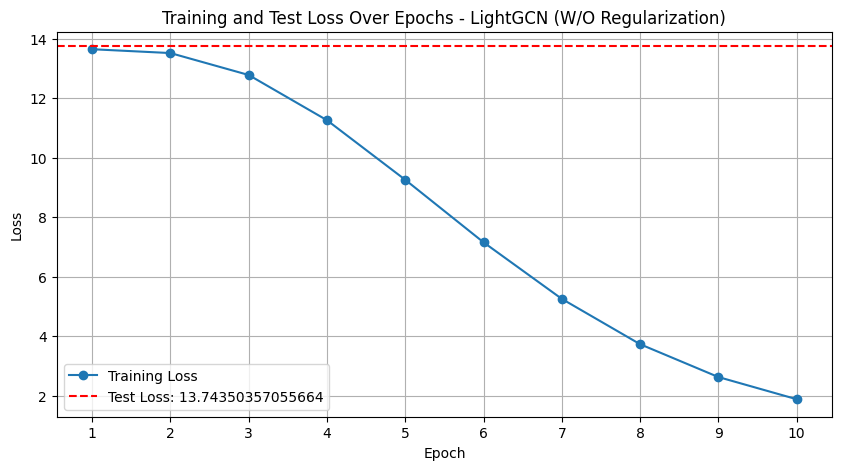

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data['Epoch'], data['Training Loss'], label='Training Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss}')
plt.title('Training and Test Loss Over Epochs - LightGCN (W/O Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # Ensure all epochs are marked
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the epochs and corresponding training losses
epochs = np.arange(1, 11)
training_losses = [13.6678, 13.6453, 13.6470, 13.6469, 13.6472, 13.6472, 13.6473, 13.6473, 13.6473, 13.6473]

# Define the test loss
test_loss = 13.620323181152344

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': training_losses
})


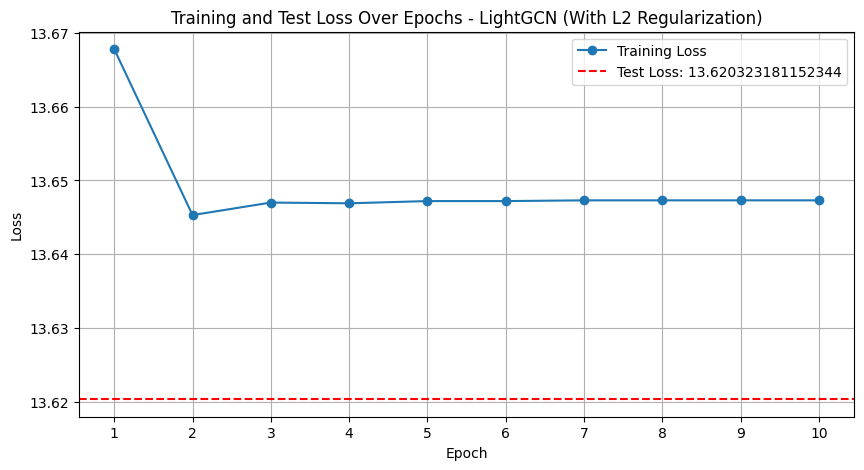

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data['Epoch'], data['Training Loss'], label='Training Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss}')
plt.title('Training and Test Loss Over Epochs - LightGCN (With L2 Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # Ensure all epochs are marked
plt.legend()
plt.grid(True)
plt.show()


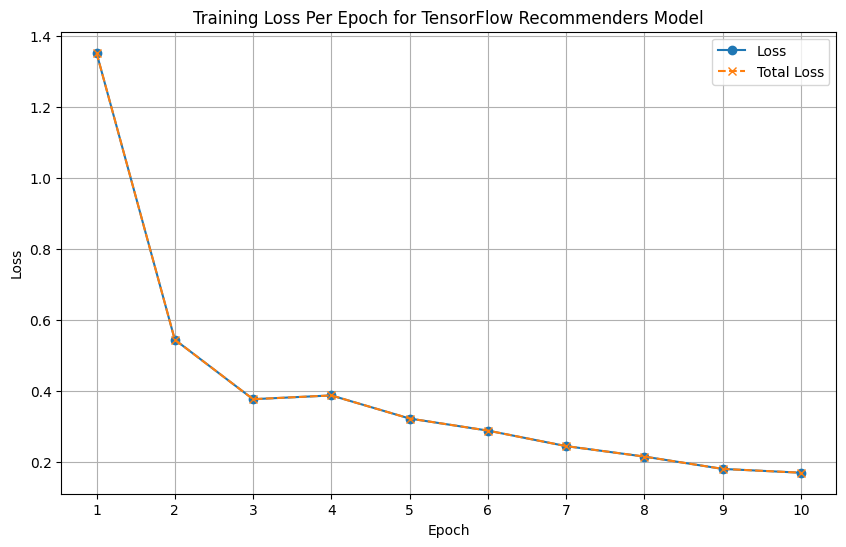

In [ ]:
import matplotlib.pyplot as plt

# Define the epochs
epochs = list(range(1, 11))

# Define the losses for each epoch
losses = [1.3525, 0.5444, 0.3767, 0.3873, 0.3222, 0.2882, 0.2445, 0.2150, 0.1803, 0.1696]
total_losses = [1.3525, 0.5444, 0.3767, 0.3873, 0.3222, 0.2882, 0.2445, 0.2150, 0.1803, 0.1696]

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label='Loss', marker='o')
plt.plot(epochs, total_losses, label='Total Loss', linestyle='--', marker='x')

# Adding plot details
plt.title('Training Loss Per Epoch for TensorFlow Recommenders Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()
